In [1]:
import torch
import os
import grakel

import numpy as np
import matplotlib.pyplot as plt


from __future__ import print_function
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from torch_geometric.data import Data


def list_to_dict(l):
    """Convert list to dict"""
    return {val: i for i, val in enumerate(l)}


node_encoding = list_to_dict(
    [
        "ala",
        "arg",
        "asn",
        "asp",
        "cys",
        "gln",
        "glu",
        "gly",
        "his",
        "ile",
        "leu",
        "lys",
        "met",
        "phe",
        "pro",
        "ser",
        "thr",
        "trp",
        "tyr",
        "val",
    ]
)


class Atom:
    """Atom class"""

    def __init__(self, line: str) -> None:
        self.serial = int(line[6:11].strip())
        self.name = line[12:16].strip()
        self.altLoc = line[16].strip()
        self.resName = line[17:20].strip()
        self.chainID = line[21].strip()
        self.num = int(line[22:26].strip())
        self.iCode = line[26].strip()
        self.x = float(line[30:38].strip())
        self.y = float(line[38:46].strip())
        self.z = float(line[46:54].strip())
        self.occupancy = float(line[54:60].strip())
        self.tempFactor = float(line[60:66].strip())
        self.element = line[76:78].strip()
        self.charge = line[78:80].strip()

    def __repr__(self) -> str:
        return f"{self.serial} {self.name}"


class Residue:
    """Residue class"""

    def __init__(self, line: str) -> None:
        self.name = line[17:20].strip()
        self.num = int(line[22:26].strip())
        self.chainID = line[21].strip()
        self.atoms = []

    def add_atom(self, atom: Atom) -> None:
        self.atoms.append(atom)

    def __repr__(self) -> str:
        return f"{self.num} {self.name}"


class Structure:
    """Structure class"""

    def __init__(self, filename: str) -> None:
        self.residues = {}
        self.atoms = {}
        self.parse_file(filename)

    def parse_file(self, filename: str) -> None:
        """Parse PDB file"""
        for line in open(filename, "r"):
            if line.startswith("ATOM") and line[12:16].strip() == "CA":
                atom = Atom(line)
                self.atoms[atom.serial] = atom
                if atom.num not in self.residues:
                    self.residues[atom.num] = Residue(line)
                self.residues[atom.num].add_atom(atom)

    def __repr__(self) -> str:
        return f"{self.residues}"

    def __get__(self, key: int) -> Atom:
        return self.atoms[key]

    def get_coords(self) -> torch.Tensor:
        """Get coordinates of all atoms"""
        coords = [[atom.x, atom.y, atom.z] for atom in self.atoms.values()]
        return torch.tensor(coords)

    def get_nodes(self) -> torch.Tensor:
        """Get features of all nodes of a graph"""
        return torch.tensor([node_encoding[res.name.lower()] + 1 for res in self.residues.values()])

    def get_edges(self, threshold: float) -> torch.Tensor:
        """Get edges of a graph using threshold as a cutoff"""
        coords = self.get_coords()
        dist = torch.cdist(coords, coords)
        edges = torch.where(dist < threshold)
        edges = torch.cat([arr.view(-1, 1) for arr in edges], axis=1)
        edges = edges[edges[:, 0] != edges[:, 1]]
        return edges.t()

    def get_graph(self, threshold: float) -> Data:
        """Get a graph using threshold as a cutoff"""
        nodes = self.get_nodes()
        edges = self.get_edges(threshold)
        return Data(x=nodes, edge_index=edges)


In [2]:
#the inputs for the directory containing the PDB files, and the number of files to be analysed
directory = input()
Protein_count = int(input())

TM_align_PDB's
200


In [3]:
#makes sure only to take the PDBs from the directory, also just the number wanted
file_list = []
counter = 0
for f in os.listdir(directory):
    if counter >= Protein_count:
        break
    if f.endswith(".pdb"):
        file_list.append(f)
        counter += 1

file_list = sorted(file_list, key=str.lower)

['12asA.pdb', '16pk_.pdb', '16vpA.pdb', '19hcA.pdb', '1a02N.pdb', '1a04A.pdb', '1a06_.pdb', '1a0aA.pdb', '1a0cA.pdb', '1a0fA.pdb', '1a0i_.pdb', '1a0p_.pdb', '1a0tP.pdb', '1a12A.pdb', '1a17_.pdb', '1a1iA.pdb', '1a1w_.pdb', '1a1x_.pdb', '1a28A.pdb', '1a2oA.pdb', '1a2pA.pdb', '1a2vA.pdb', '1a2zA.pdb', '1a31A.pdb', '1a32_.pdb', '1a3aA.pdb', '1a3c_.pdb', '1a3qA.pdb', '1a41_.pdb', '1a44_.pdb', '1a48_.pdb', '1a4mA.pdb', '1a4sA.pdb', '1a4yA.pdb', '1a53_.pdb', '1a59_.pdb', '1a5t_.pdb', '1a62_.pdb', '1a6cA.pdb', '1a6dA.pdb', '1a6f_.pdb', '1a6jA.pdb', '1a6q_.pdb', '1a6s_.pdb', '1a73A.pdb', '1a77_.pdb', '1a79A.pdb', '1a7s_.pdb', '1a7tA.pdb', '1a8d_.pdb', '1a8e_.pdb', '1a8h_.pdb', '1a8i_.pdb', '1a8l_.pdb', '1a8o_.pdb', '1a8p_.pdb', '1a8q_.pdb', '1a8y_.pdb', '1a99A.pdb', '1a9nA.pdb', '1a9xA.pdb', '1aa6_.pdb', '1aa7A.pdb', '1ab4_.pdb', '1abrB.pdb', '1abv_.pdb', '1ac5_.pdb', '1ac6A.pdb', '1acf_.pdb', '1aco_.pdb', '1ad1A.pdb', '1ad3A.pdb', '1adn_.pdb', '1adr_.pdb', '1adt_.pdb', '1ae9A.pdb', '1aep_.pdb'

In [4]:
#creates the number to the corresponding PDB file and creates their graph structure

data_list, graph_list = [], []
for file in file_list:
    my_edges, my_node_labels = dict(), dict()
    filename = directory + "/" + file
    structure = Structure(filename)
    
    my_edges, my_node_labels = dict(), dict()

    index = 0
    sources, targets = structure.get_edges(10)[0], structure.get_edges(10)[1]
    
    for index in range(len(sources)):
        source, target = sources[index].item(), targets[index].item()
        if source in my_edges:
            my_edges[source].append(target)
        else:
            my_edges[source] = [target]
            if source >= len(structure.get_nodes()):
                my_node_labels[source] = 0
            else:
                my_node_labels[source] = structure.get_nodes()[source].item()
    
    graph_list.append(grakel.Graph(my_edges, node_labels=my_node_labels))

12asA.pdb
16pk_.pdb
16vpA.pdb
19hcA.pdb
1a02N.pdb
1a04A.pdb
1a06_.pdb
1a0aA.pdb
1a0cA.pdb
1a0fA.pdb
1a0i_.pdb
1a0p_.pdb
1a0tP.pdb
1a12A.pdb
1a17_.pdb
1a1iA.pdb
1a1w_.pdb
1a1x_.pdb
1a28A.pdb
1a2oA.pdb
1a2pA.pdb
1a2vA.pdb
1a2zA.pdb
1a31A.pdb
1a32_.pdb
1a3aA.pdb
1a3c_.pdb
1a3qA.pdb
1a41_.pdb
1a44_.pdb
1a48_.pdb
1a4mA.pdb
1a4sA.pdb
1a4yA.pdb
1a53_.pdb
1a59_.pdb
1a5t_.pdb
1a62_.pdb
1a6cA.pdb
1a6dA.pdb
1a6f_.pdb
1a6jA.pdb
1a6q_.pdb
1a6s_.pdb
1a73A.pdb
1a77_.pdb
1a79A.pdb
1a7s_.pdb
1a7tA.pdb
1a8d_.pdb
1a8e_.pdb
1a8h_.pdb
1a8i_.pdb
1a8l_.pdb
1a8o_.pdb
1a8p_.pdb
1a8q_.pdb
1a8y_.pdb
1a99A.pdb
1a9nA.pdb
1a9xA.pdb
1aa6_.pdb
1aa7A.pdb
1ab4_.pdb
1abrB.pdb
1abv_.pdb
1ac5_.pdb
1ac6A.pdb
1acf_.pdb
1aco_.pdb
1ad1A.pdb
1ad3A.pdb
1adn_.pdb
1adr_.pdb
1adt_.pdb
1ae9A.pdb
1aep_.pdb
1af7_.pdb
1af8_.pdb
1afj_.pdb
1afrA.pdb
1afwA.pdb
1agg_.pdb
1agi_.pdb
1agjA.pdb
1agqA.pdb
1ah7_.pdb
1aho_.pdb
1ahsA.pdb
1air_.pdb
1aisA.pdb
1aisB.pdb
1aiw_.pdb
1ajsA.pdb
1ak0_.pdb
1ak4C.pdb
1ak5_.pdb
1ak7_.pdb
1akhA.pdb
1akjD.pdb


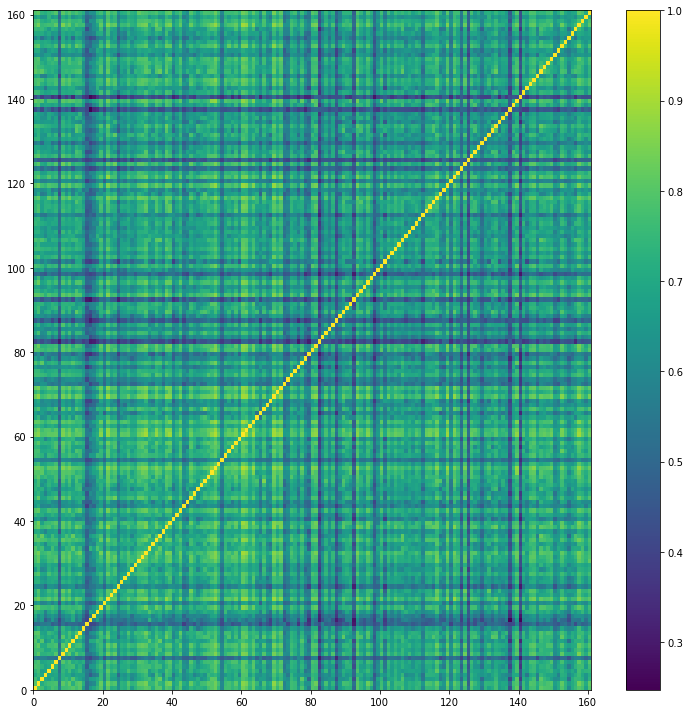

CPU times: user 1.95 s, sys: 341 ms, total: 2.3 s
Wall time: 1.01 s


In [6]:
#running th WL subgraph kernels and ploting the results

gk = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
result = gk.fit_transform(graph_list)

plt.rcParams["figure.figsize"] = (12.5,12.5)

plt.pcolormesh(result)
plt.colorbar()
plt.show()